In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.linear_model import SGDClassifier as SVC
from copy import deepcopy
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings("ignore")
from __future__ import print_function

In [2]:
def get_graph():
    X = np.array([[i/1000] for i in range(0, 1010)])
    preds = sess.run(y, feed_dict={input_layer: X.reshape(-1,1)})
    plt.plot(X.reshape(-1), preds)
    plt.show()

def get_graph_sk(model):
    # рисует график функции предсказания для sklearn модели
    X = np.array([[i/1000] for i in range(0, 1010)])
    preds = model.predict_proba(X)[:,1].reshape(-1)
    plt.plot(X.reshape(-1), preds)
    plt.show()
    
def get_s_y(arr):
    # рисует что-то типа плотности вероятности для переданного листа
    support = np.array([[i/1000] for i in range(50, 1000, 10)])
    y = [len(arr[np.abs(elem - arr) <= 0.005]) for elem in support]
    return support, y

def norm(evaluated_gradients):
    # Вычисляет норму переданных градиентов
    kek = np.array([])
    for elem in evaluated_gradients:
        kek = np.append(kek, elem)
    return np.linalg.norm(kek)

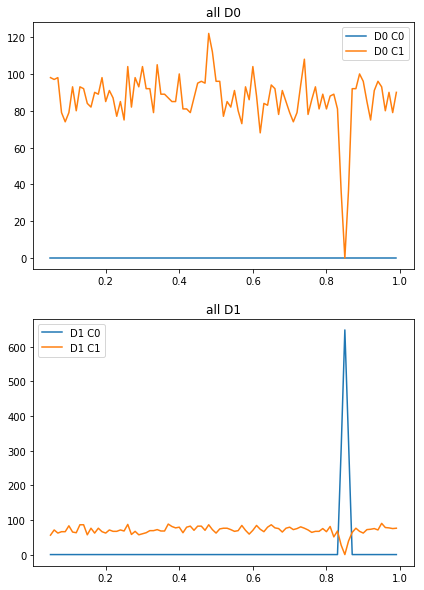

0.490120908287


In [3]:
C0_size = 1280
C1_size = 16000
center = 0.85

C0 = np.random.uniform(low=0.84, high=0.86, size=C0_size)
C1 = np.random.uniform(low=0, high=1, size=(C1_size,))
C1 = C1[[i for i,elem in enumerate(C1) if (np.abs(elem-center) >= 0.01) ]]

dataset = np.concatenate((C0, C1), axis=0)
C1_labels = np.concatenate(([0]*len(C0), [1]*len(C1)))
D1_labels = np.arange(len(dataset))

D1_labels[C1_labels==0] = np.random.binomial(1, 1, size=(len(C1_labels) - C1_labels.sum(),))
D1_labels[C1_labels==1] = np.random.binomial(1, 0.45, size=(C1_labels.sum(),))

plt.figure(figsize=(15,10))

plt.subplot(221)
plt.title('all D0')
s, p1 = get_s_y(dataset[(C1_labels==0) * (D1_labels==0)])
s, p2 = get_s_y(dataset[(C1_labels==1) * (D1_labels==0)])
plt.plot(s, p1, label='D0 C0')
plt.plot(s, p2, label='D0 C1')
plt.legend()

plt.subplot(223)
plt.title('all D1')
s, p3 = get_s_y(dataset[(C1_labels==0) * (D1_labels==1)])
s, p4 = get_s_y(dataset[(C1_labels==1) * (D1_labels==1)])
plt.plot(s, p3, label='D1 C0')
plt.plot(s, p4, label='D1 C1')
plt.legend()

plt.show()

print(D1_labels.sum()/ len(D1_labels))

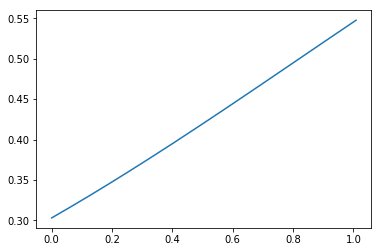

In [4]:
svm = SVC(loss='log')
svm.fit(dataset.reshape(-1,1), D1_labels.reshape(-1,1))
get_graph_sk(svm)

In [32]:
input_layer = tf.placeholder(tf.float32, [None, 1])

W1 = tf.Variable(np.random.randn(1,128).astype(np.float32))
b1 = tf.Variable(np.random.randn(128).astype(np.float32))
c1 = tf.nn.tanh(tf.matmul(input_layer, W1) + b1)

W2 = tf.Variable(np.random.randn(128,64).astype(np.float32))
b2 = tf.Variable(np.random.randn(64).astype(np.float32))
c2 = tf.nn.tanh(tf.matmul(c1, W2) + b2)

W3 = tf.Variable(np.random.randn(64,32).astype(np.float32))
b3 = tf.Variable(np.random.randn(32).astype(np.float32))
c3 = tf.nn.tanh(tf.matmul(c2, W3) + b3)

W4 = tf.Variable(np.random.randn(32,1).astype(np.float32))
b4 = tf.Variable(np.random.randn(1).astype(np.float32))
logits = tf.matmul(c3, W4) + b4
y = tf.nn.sigmoid(logits)

y_ = tf.placeholder(tf.float32, [None, 1])
constants = tf.placeholder(tf.float32, [None, 1])

loss = tf.reduce_sum(
    tf.multiply(tf.nn.sigmoid_cross_entropy_with_logits(labels=y_, logits=logits),
               constants)
    )
train_step = tf.train.AdamOptimizer().minimize(loss)

trainable = [W1,W2,W3,W4,b1,b2,b3,b4]
grads = tf.gradients(loss, trainable)

correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

In [33]:
d1 = dataset[D1_labels == 1]
d0 = dataset[D1_labels == 0]

pairs = np.zeros((len(d1), 2), dtype=int)
pairs[:,1] = np.arange(len(d1))

svm_preds_d1 = svm.predict_proba(d1.reshape(-1,1))[:,1].reshape(-1,)
svm_preds_d0 = svm.predict_proba(d0.reshape(-1,1))[:,1].reshape(-1,)

svm_preds_d0_temp = svm_preds_d0.copy()
for i in range(len(pairs)):
    pairs[i,0] = np.argmin(np.abs(svm_preds_d0_temp - svm_preds_d1[i]))
    svm_preds_d0_temp = np.delete(svm_preds_d0_temp, 
                        np.min(np.abs(svm_preds_d0_temp - svm_preds_d1[i])))

In [34]:
all_probs = np.array([[1/len(pairs)]*len(pairs)])
c = np.array([1/len(pairs)]*len(pairs)).reshape(-1,1)
k = 0
probs = np.array([1/len(pairs)]*len(pairs))
for _ in tqdm_notebook(range(400)):
    k+=1
    if k % 10 == 5:
        probs = np.zeros((len(pairs),))
        for i,elem in enumerate(pairs): # пересчитываем вероятности
            batch_of_two = np.array([d0[elem[0]],d1[elem[1]]]).reshape(2,-1)
            probs[i] = norm(sess.run(grads, feed_dict={input_layer:batch_of_two, 
                                                       y_:np.array([[0],[1]]),
                                                       constants:np.array([c[i], c[i]]).reshape(-1,1)}))
        probs = (probs) / (probs).sum()
        probs[probs < (len(pairs) * 1.1) ** (-1)] = (len(pairs) * 1.1) ** (-1) # не даём вероятностям стать слишком маленькими 
        probs[probs > (len(pairs) / 1.1) ** (-1)] = (len(pairs) / 1.1) ** (-1) # или большими
        probs = probs / probs.sum()
    
    all_probs = np.append(all_probs, probs.reshape(1,-1), axis=0)
    nice = np.random.choice(np.arange(len(pairs)), size=750, p=probs)
    nice = pairs[nice]
    nice_batch = np.array([])
    nice_batch_y = np.array([])
    nice_batch = np.append(nice_batch, d0[nice[:,0]])
    nice_batch_y = np.append(nice_batch_y, np.zeros((len(nice),), dtype=int))
    nice_batch = np.append(nice_batch, d1[nice[:,1]])
    nice_batch_y = np.append(nice_batch_y, np.ones((len(nice),), dtype=int))
    c_temp = (np.array([1/len(pairs)]*len(pairs)) / probs)[nice[:,1]]
    #print(c_temp)
    c_temp = c_temp.reshape(-1,1)
    l,_ = sess.run([loss, train_step], feed_dict={input_layer: nice_batch.reshape(-1,1),
                                                  y_: nice_batch_y.reshape(-1,1),
                                                  constants: np.concatenate([c_temp,c_temp])})
    """ol = np.array([1/len(pairs)]*len(pairs)).reshape(-1,1)[nice[:,1]]
    nice_losses.append(sess.run([loss], feed_dict={input_layer: nice_batch.reshape(-1,1),
                                                  y_: nice_batch_y.reshape(-1,1),
                                                  constants: np.concatenate([ol,ol])}))"""

HBox(children=(IntProgress(value=0, max=400), HTML(value='')))

383/|/ 96%|| 383/400 [09:30<00:25,  1.49s/it]


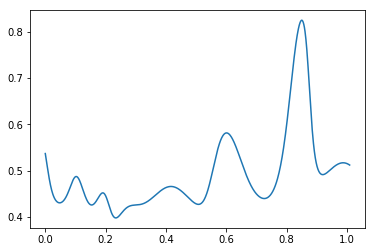

In [35]:
get_graph()

In [ ]:
(np.array([1/len(pairs)]*len(pairs)) * (1/probs))[nice[:,1]].shape

In [18]:
bad_losses

[[5.8261003],
 [5.2128124],
 [4.6185274],
 [4.0637698],
 [3.5894895],
 [3.2104647],
 [2.740205],
 [2.2748752],
 [1.9915251],
 [1.8435717],
 [1.8271942],
 [1.7679366],
 [1.7385601],
 [1.7615001],
 [1.7529526],
 [1.730629],
 [1.699134],
 [1.6362209],
 [1.5627224],
 [1.4922309],
 [1.4472612],
 [1.4063298],
 [1.3840697],
 [1.3700073],
 [1.358925],
 [1.3509984],
 [1.3408614],
 [1.3369975],
 [1.3103817],
 [1.3010603],
 [1.2849443],
 [1.2868916],
 [1.284655],
 [1.2819912],
 [1.2871933],
 [1.2812285],
 [1.2763923],
 [1.2805266],
 [1.2668693],
 [1.2681029],
 [1.251538],
 [1.2530158],
 [1.2466524],
 [1.2440567],
 [1.2422163],
 [1.2356478],
 [1.23133],
 [1.2310157],
 [1.2206662],
 [1.2195151],
 [1.2179444],
 [1.2148161],
 [1.2148035],
 [1.2184385],
 [1.2098892],
 [1.2134688],
 [1.2127221],
 [1.2095571],
 [1.2094748],
 [1.2104139],
 [1.2112007],
 [1.2091551],
 [1.205579],
 [1.2092931],
 [1.2081984],
 [1.2068771],
 [1.2048358],
 [1.2047577],
 [1.205617],
 [1.2084203],
 [1.2007103],
 [1.2046455],
 [

In [8]:
nice_losses = []

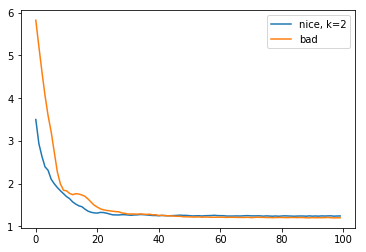

In [34]:
plt.plot(nice_losses, label='nice, k=2')
plt.plot(bad_losses, label='bad')
plt.legend()
plt.show()

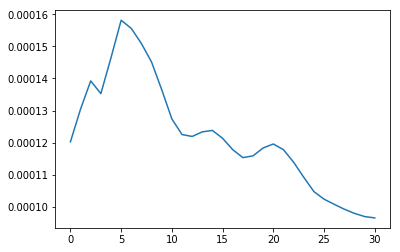

In [41]:
plt.plot(all_probs[:,4])
plt.show()

In [64]:
pairs[:,1][np.abs(d1-center) < 0.01]

array([   0,    1,    2, ..., 1277, 1278, 1279])

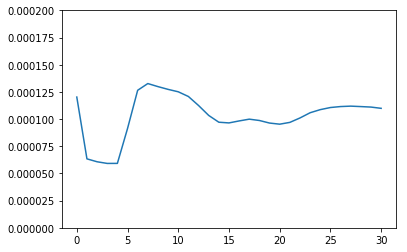

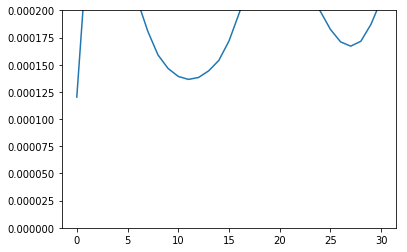

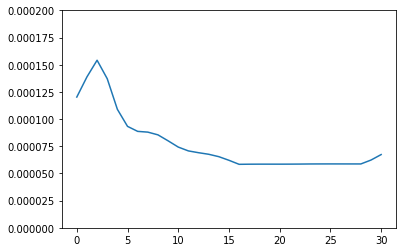

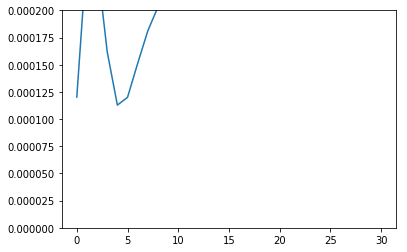

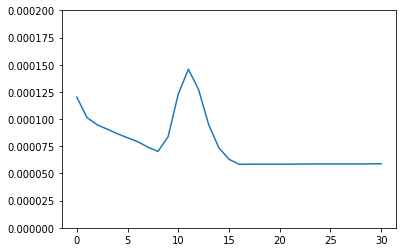

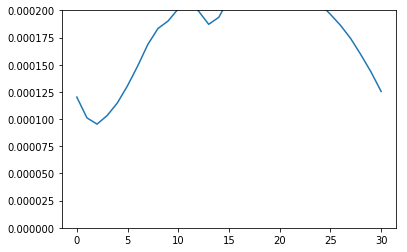

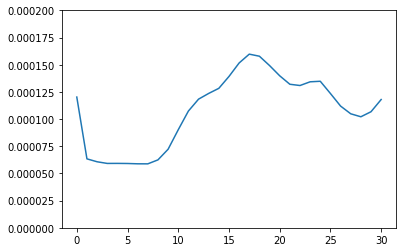

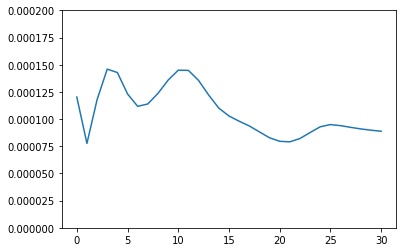

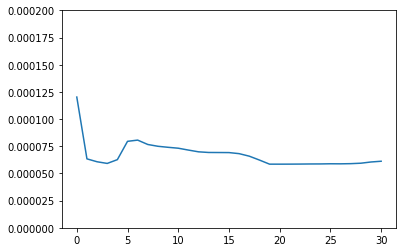

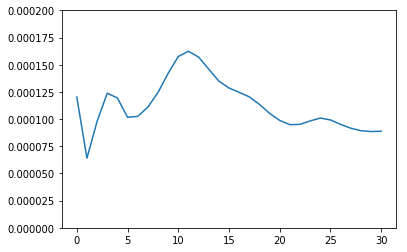

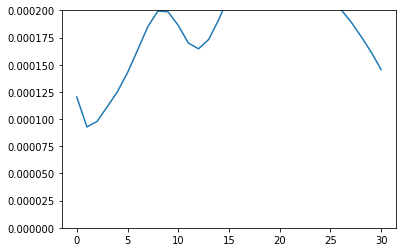

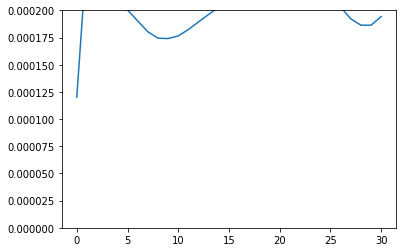

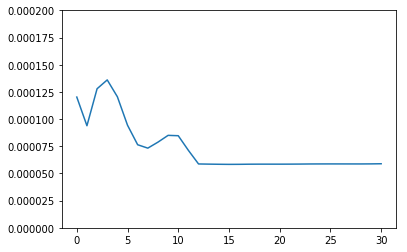

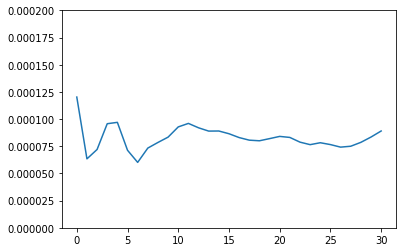

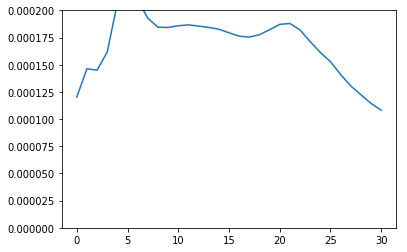

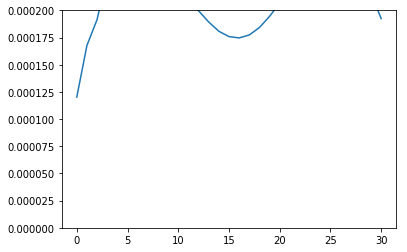

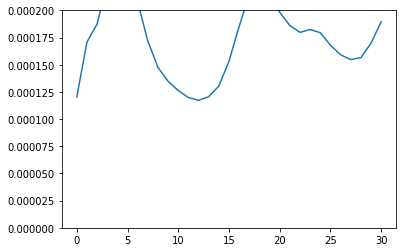

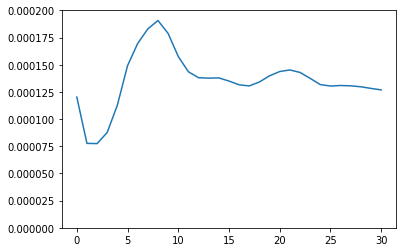

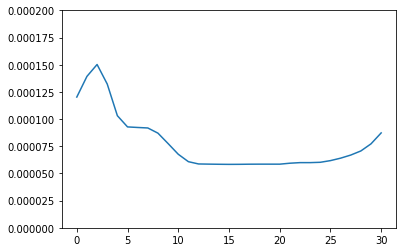

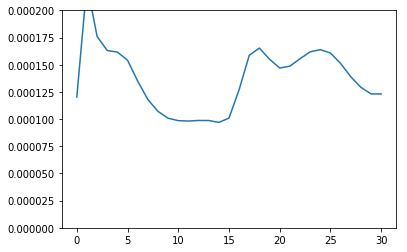

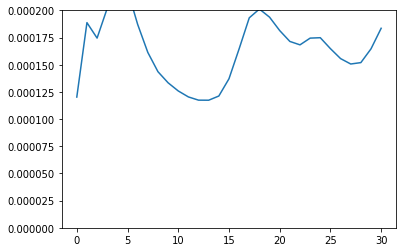

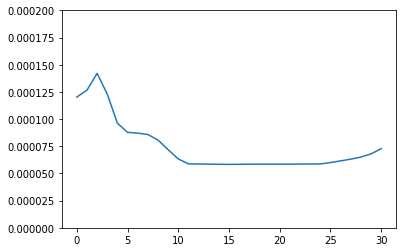

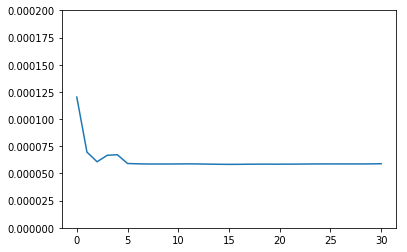

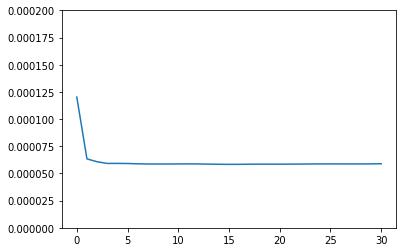

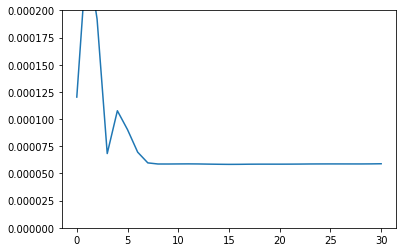

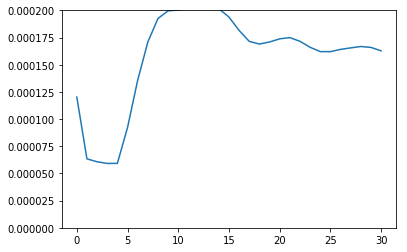

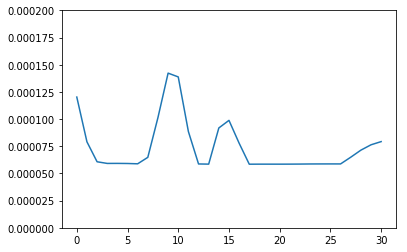

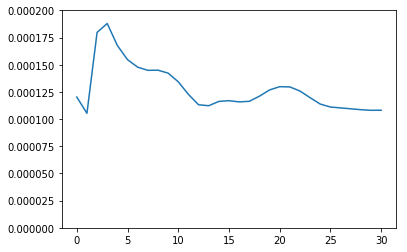

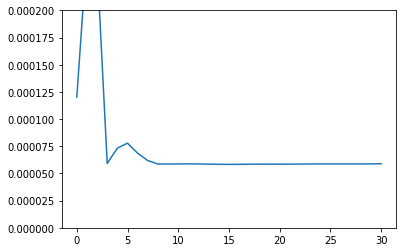

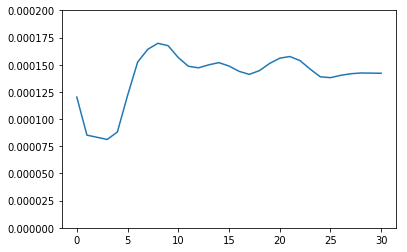

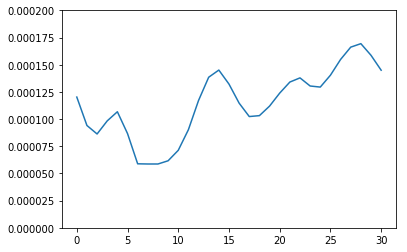

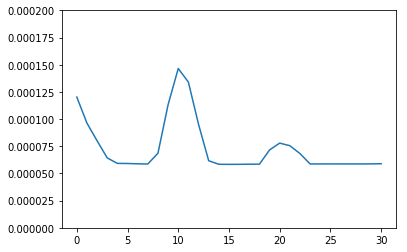

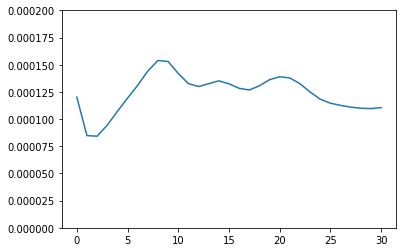

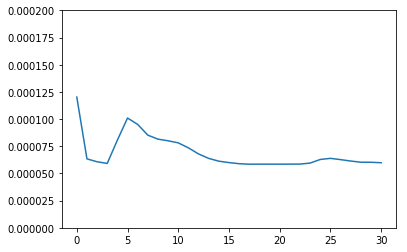

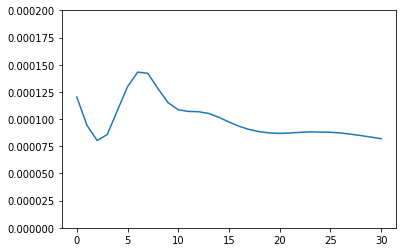

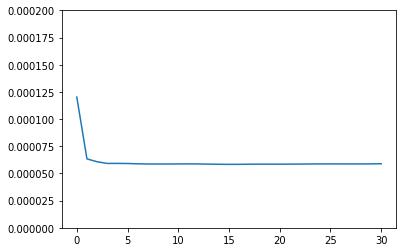

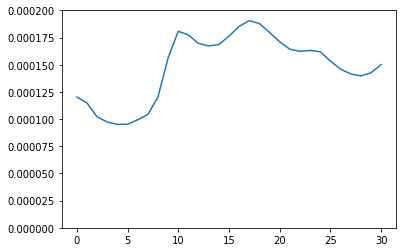

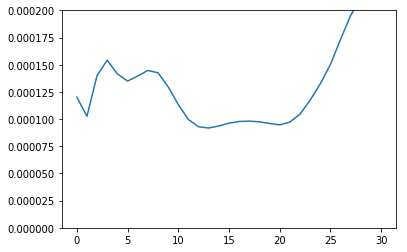

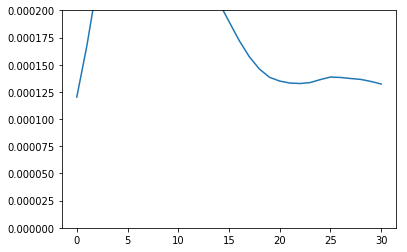

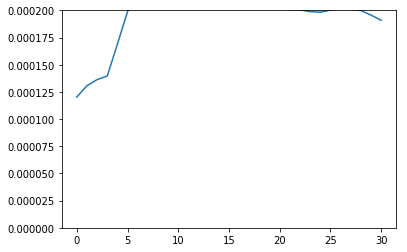

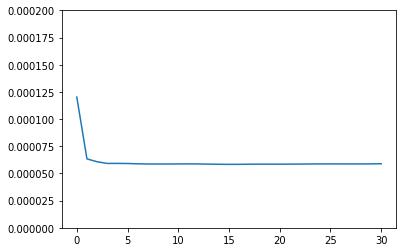

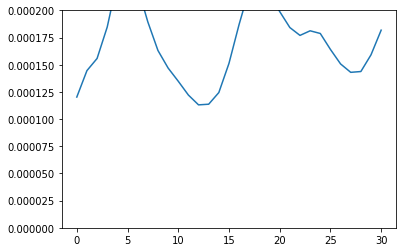

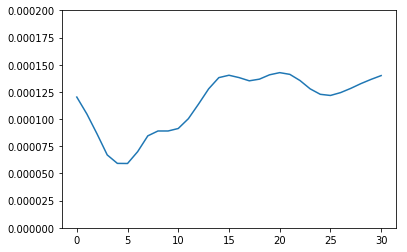

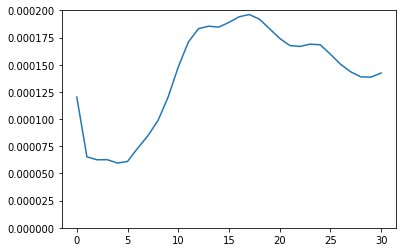

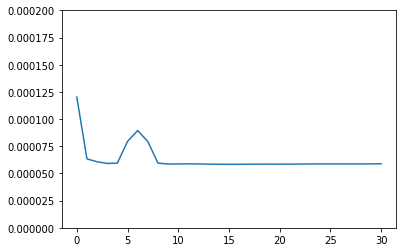

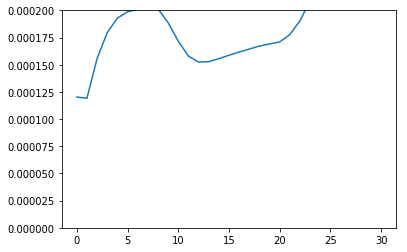

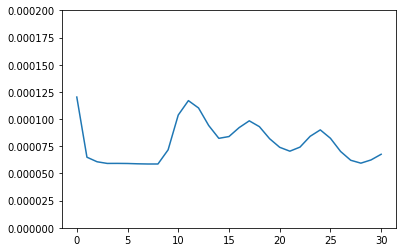

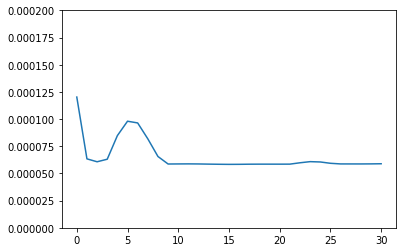

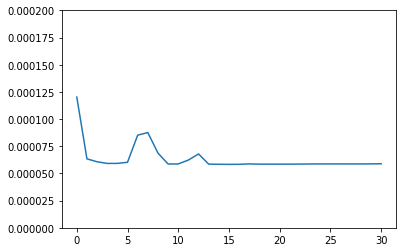

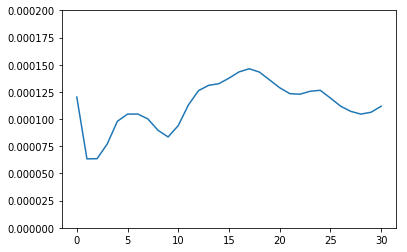

In [108]:
for i in range(1300,1350):
    plt.plot(all_probs[:,i])
    axes = plt.gca()
    axes.set_ylim([0,0.0002])
    plt.show()

In [52]:
pairs[:,0]

array([   0,    1,    2, ..., 8313, 8314, 8315])

In [55]:
d1[1280]

0.39957365257041844

In [79]:
np.mean(all_probs[:1279,:],axis=1)

array([ 0.00012025,  0.00012025,  0.00012025,  0.00012025,  0.00012025,
        0.00012025,  0.00012025,  0.00012025,  0.00012025,  0.00012025,
        0.00012025,  0.00012025,  0.00012025,  0.00012025,  0.00012025,
        0.00012025,  0.00012025,  0.00012025,  0.00012025,  0.00012025,
        0.00012025,  0.00012025,  0.00012025,  0.00012025,  0.00012025,
        0.00012025,  0.00012025,  0.00012025,  0.00012025,  0.00012025,
        0.00012025])

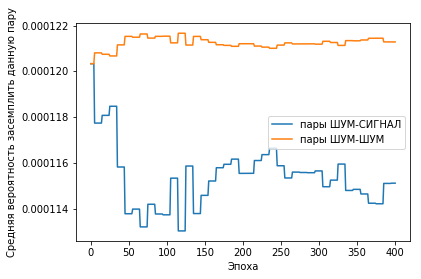

In [36]:
plt.plot(np.mean(all_probs[:,:1280],axis=1), label='пары ШУМ-СИГНАЛ')
plt.plot(np.mean(all_probs[:,1280:],axis=1), label='пары ШУМ-ШУМ')
plt.xlabel('Эпоха')
plt.ylabel('Средняя вероятность засемплить данную пару')
plt.legend()
plt.show()